# Source: https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

In [1]:
import numpy as np
import sklearn
import scipy.linalg as LA
import matplotlib.pyplot as plt

seed = 42
rng = np.random.default_rng(seed)

## Import test image from scipy

In [2]:
from scipy.datasets import face

raccoon_face = face(gray=True).astype(np.float64)

# normalize
raccoon_face /= 255.0

# downsample for speed
raccoon_face = raccoon_face[::4, ::4] + raccoon_face[2::4, ::4] + raccoon_face[::4, 2::4] + raccoon_face[2::4, 2::4]
raccoon_face /= 4
height, width = raccoon_face.shape

# Distort the right half of the image
print('Distorting image')
distorted = raccoon_face.copy()
distorted[:, width // 2:] += .075 * rng.standard_normal(size=(height, width // 2))

Distorting image


## Display distorted image

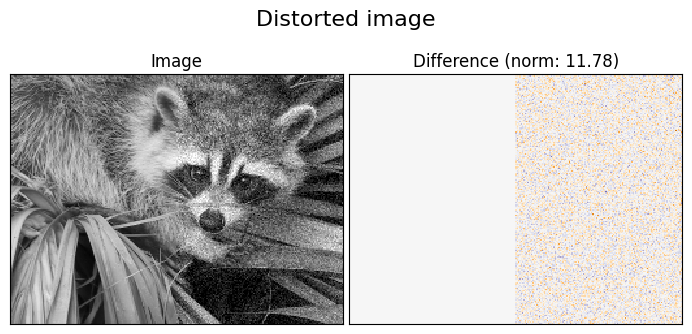

In [3]:
def show_with_diff(image, reference, title):
    plt.figure(figsize=(7, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation='nearest'
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(.02, .02, .98, .79, .02, .2)

show_with_diff(distorted, raccoon_face, 'Distorted image')

## Extract reference patches

In [4]:
from time import time
from sklearn.feature_extraction.image import extract_patches_2d

# Extract patches from left half of the image
print('Extracting reference patches')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f'{data.shape[0]} patches extracted in %.2fs.' % (time() - t0))

Extracting reference patches
22692 patches extracted in 0.01s.


# Inital KSVD implementation

In [5]:
from sklearn.decomposition import SparseCoder

def kSVD(Y, T_0, k, num_iter, track_loss = True, verbose:int = 0):
    loss = np.empty(num_iter)

    # Initialize dictionary
    t0 = time()
    D = rng.standard_normal(size=(k, Y.shape[1]))
    D = np.diag(1 / LA.norm(D, ord=2, axis=1)) @ D

    if verbose > 0:
        print(f'Initialization Time: {time() - t0}')
    
    for iter in range(num_iter):
        t0 = 0
        if verbose > 0:
            print(f'Iteration {iter}:')
            t0 = time()
        
        # Sparse Coding Step
        # if debug:
        #     print(f'Iteration {iter}, Sparse Coding Step...')
        
        X = SparseCoder(dictionary = D, transform_n_nonzero_coefs = T_0).transform(Y)
        if verbose > 0:
            print(f'\tCoding Time: {time() - t0}')
        
        # Dictionary Update Step
        # if debug:
        #     print(f'Iteration {iter}, Dictionary Update Step...')
        t0 = time()
        unused_atom = False
        for i in range(k):
            x_i = X[:, i]
            filter = (x_i != 0)
            x_i_R = x_i[filter]
            if x_i_R.shape[0] == 0:
                # print('Warning: Dictionary atom unused? Skipping update...')
                unused_atom=True
                continue
            
            E_k_R = Y[filter]
            for j in range(k):
                if j != i:
                    # print(X[filter, j][:, np.newaxis].shape)
                    # print(D[j][np.newaxis, :].shape)
                    E_k_R -= X[filter, j][:, np.newaxis] @ D[j][np.newaxis, :]

            # print(E_k_R.shape)
            U, S, Vh = LA.svd(E_k_R)

            X[filter, i] = U[:, 0] * S[0]
            D[i] = Vh[0]

        if verbose > 0:
            print(f'\tUpdate Time: {time() - t0}')
            print(f'\tUnused Atom: {unused_atom}')
        
        loss[iter] = LA.norm(Y - X @ D, ord='fro')

    return D, loss

In [6]:
def plot_log_loss(loss, linestyle='-', alpha = 1):
    plt.semilogy(loss, linestyle=linestyle, alpha = alpha)
    plt.title('Loss vs iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Log Scale)')
    # plt.show()

## Learn the dictionary from reference patches

### Hyperparams have been set to try to match those in the sklearn example and the results obtained for a more fair comparison!

In [7]:
%%timeit
num_iter = 2
Y = data
D, loss = kSVD(Y = Y,
               T_0 = 1, 
               k = 50, 
               num_iter = num_iter, 
               verbose=1) 

Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.7256805896759033
	Update Time: 5.674107789993286
	Unused Atom: False
Iteration 1:
	Coding Time: 0.5670373439788818
	Update Time: 2.575622320175171
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.4990255832672119
	Update Time: 6.988973617553711
	Unused Atom: False
Iteration 1:
	Coding Time: 0.5016992092132568
	Update Time: 3.064967393875122
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.4920332431793213
	Update Time: 5.409963369369507
	Unused Atom: False
Iteration 1:
	Coding Time: 0.4979979991912842
	Update Time: 2.727273464202881
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.5320346355438232
	Update Time: 5.983800888061523
	Unused Atom: False
Iteration 1:
	Coding Time: 0.6230356693267822
	Update Time: 3.0634825229644775
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.4920327663421631
	Update Time: 4.66361403465271
	Unused Atom:

Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.5374739170074463
	Update Time: 4.961700439453125
	Unused Atom: False
Iteration 1:
	Coding Time: 0.4950265884399414
	Update Time: 2.553088426589966
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.514031171798706
	Update Time: 5.711969614028931
	Unused Atom: False
Iteration 1:
	Coding Time: 0.5001606941223145
	Update Time: 2.930983781814575
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.5070312023162842
	Update Time: 3.491347551345825
	Unused Atom: False
Iteration 1:
	Coding Time: 0.5071694850921631
	Update Time: 2.3330957889556885
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.5859951972961426
	Update Time: 3.605970621109009
	Unused Atom: False
Iteration 1:
	Coding Time: 0.5390243530273438
	Update Time: 1.861043930053711
	Unused Atom: False
Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.5010271072387695
	Update Time: 5.0913145542144775
	Unused Atom

(array([ 4., 17., 10.,  7.,  4.,  4.,  1.,  2.,  0.,  1.]),
 array([ 3.91049051,  5.57797287,  7.24545522,  8.91293757, 10.58041992,
        12.24790227, 13.91538463, 15.58286698, 17.25034933, 18.91783168,
        20.58531404]),
 <BarContainer object of 10 artists>)

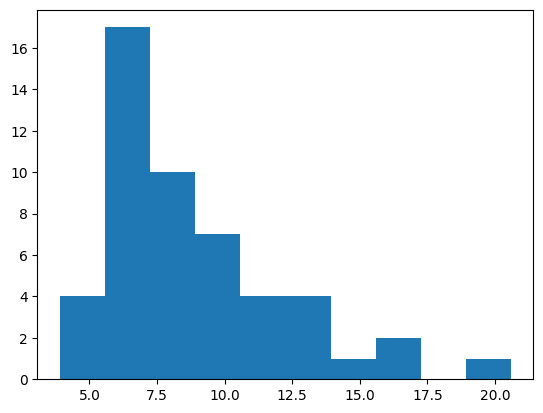

In [8]:
num_iter = 2
Y = data

times = []
final_losses = []
for i in range(50):
    t0 = time()
    D, loss = kSVD(Y = Y, 
                   T_0 = 1, 
                   k = 50, 
                   num_iter = num_iter, 
                   verbose=1)
    times.append(time() - t0)
    final_losses.append(loss[-1])

plt.hist(times)

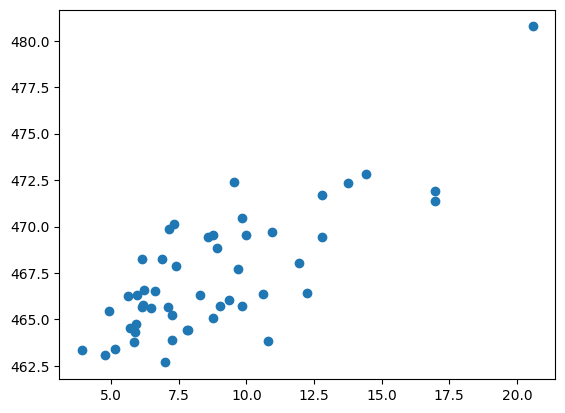

In [9]:
plt.scatter(times, final_losses)

# Compare with MiniBatchDictionaryLearning used in the scikit-learn example

In [10]:
from sklearn.decomposition import MiniBatchDictionaryLearning

In [11]:
%%timeit
dico = MiniBatchDictionaryLearning(
    n_components=50,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
    random_state = seed,
)
V = dico.fit(data).components_

13.3 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(array([17., 20.,  6.,  4.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([13.00855947, 13.15404792, 13.29953637, 13.44502482, 13.59051328,
        13.73600173, 13.88149018, 14.02697864, 14.17246709, 14.31795554,
        14.46344399]),
 <BarContainer object of 10 artists>)

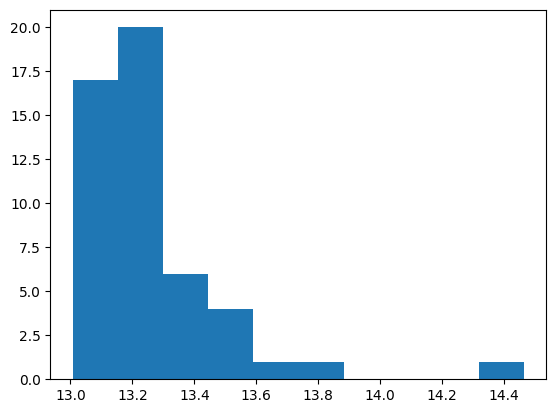

In [12]:
times = []
for i in range(50):
    t0 = time()
    dico = MiniBatchDictionaryLearning(
        n_components=50,
        batch_size=200,
        alpha=1.0,
        max_iter=10,
        random_state = seed,
    )
    V = dico.fit(data).components_
    times.append(time() - t0)

plt.hist(times)

# Going a little deeper with the profiling

## See https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html for a few examples

In [13]:
%%prun
num_iter = 2
Y = data
D, loss = kSVD(Y = Y,
               T_0 = 1, 
               k = 50, 
               num_iter = num_iter, 
               verbose=1)

Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.746025800704956
	Update Time: 2.8822648525238037
	Unused Atom: False
Iteration 1:
	Coding Time: 0.7689979076385498
	Update Time: 1.528024435043335
	Unused Atom: False
 

         912494 function calls (912492 primitive calls) in 5.951 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    3.879    0.039    3.885    0.039 _decomp_svd.py:13(svd)
    45384    0.816    0.000    1.270    0.000 _omp.py:153(_gram_omp)
        1    0.544    0.544    5.950    5.950 2902790217.py:3(kSVD)
        2    0.217    0.109    1.495    0.747 _omp.py:457(orthogonal_mp_gram)
    45384    0.075    0.000    0.075    0.000 {method 'copy' of 'numpy.ndarray' objects}
    90868    0.071    0.000    0.090    0.000 blas.py:384(getter)
    45384    0.054    0.000    0.135    0.000 fromnumeric.py:1140(argmax)
    45384    0.053    0.000    0.053    0.000 {built-in method numpy.arange}
    45384    0.039    0.000    0.039    0.000 {method 'argmax' of 'numpy.ndarray' objects}
    45384    0.033    0.000    0.081    0.000 fromnumeric.py:53(_wrapfunc)
    90769    0.032    0.000    0.032    0.000 {built-in method numpy

## Requires snakeviz to be installed if you want to run the following code locally !!!

In [14]:
# pip install snakeviz

In [15]:
%load_ext snakeviz

In [16]:
%%snakeviz 
num_iter = 2
Y = data
D, loss = kSVD(Y = Y,
               T_0 = 1, 
               k = 50, 
               num_iter = num_iter, 
               verbose=1) 

Initialization Time: 0.0009837150573730469
Iteration 0:
	Coding Time: 0.7890298366546631
	Update Time: 6.1950178146362305
	Unused Atom: False
Iteration 1:
	Coding Time: 0.8670313358306885
	Update Time: 3.1091086864471436
	Unused Atom: False
 
*** Profile stats marshalled to file 'C:\\Users\\richa\\AppData\\Local\\Temp\\tmph7y3m2fi'.
Embedding SnakeViz in this document...
<function display at 0x000001CFF74707C0>


## Requires line_profiler to be installed if you want to run the following code locally !!!

In [17]:
# pip install line_profiler

In [18]:
%load_ext line_profiler

In [19]:
from line_profiler import profile

num_iter = 2
Y = data
l_kSVD = profile(kSVD)
%lprun -f l_kSVD l_kSVD(Y = Y, \
               T_0 = 1, \
               k = 50, \
               num_iter = num_iter, verbose=1,) 

Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.80702805519104
	Update Time: 3.5145087242126465
	Unused Atom: False
Iteration 1:
	Coding Time: 0.8370304107666016
	Update Time: 1.904522180557251
	Unused Atom: False


Timer unit: 1e-07 s

Total time: 7.08309 s
File: C:\Users\richa\AppData\Local\Temp\ipykernel_4468\2902790217.py
Function: kSVD at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def kSVD(Y, T_0, k, num_iter, track_loss = True, verbose:int = 0):
     4         1         97.0     97.0      0.0      loss = np.empty(num_iter)
     5                                           
     6                                               # Initialize dictionary
     7         1          8.0      8.0      0.0      t0 = time()
     8         1        419.0    419.0      0.0      D = rng.standard_normal(size=(k, Y.shape[1]))
     9         1       2759.0   2759.0      0.0      D = np.diag(1 / LA.norm(D, ord=2, axis=1)) @ D
    10                                           
    11         1          5.0      5.0      0.0      if verbose > 0:
    12         1        925.0    925.0      0.0          print(f'Initialization Time: {time() 

## Requires memory_profiler to be installed if you want to run the following code locally !!!

In [20]:
# pip install memory_profiler

In [21]:
%load_ext memory_profiler

In [22]:
num_iter = 2
Y = data
%memit kSVD(Y = Y, \
               T_0 = 1, \
               k = 50, \
               num_iter = num_iter, verbose=1,) 

Initialization Time: 0.0
Iteration 0:
	Coding Time: 0.4929993152618408
	Update Time: 8.632923364639282
	Unused Atom: False
Iteration 1:
	Coding Time: 0.48804140090942383
	Update Time: 4.300792932510376
	Unused Atom: False
peak memory: 928.61 MiB, increment: 729.59 MiB
